In [1]:
# Read the numerical model output, make some maps to check the conditions, crop the fields of interest in the areas
# of interest and save them in a netcdf file.

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import pandas as pd

In [ ]:
# Set the paths and the file names of the (coupled) oceanic and atmospheric model outputs.
path2atm = '/mnt/storage_unimib/agostino/genoa2014/3CPLD/'
path2oce = '/mnt/storage_unimib/agostino/genoa2014/3CPLD/CPLD_HIS/'

In [41]:
# Set the instant of interest.
str_instant = '2014-10-07T12:00:00'
# Valid range: from 2014-10-06_00:00:00 to 2014-10-10_00:00:00.

atm_filename = path2atm + 'wrfout_d01_' + str_instant[:10] + '_' + str_instant[11:]
oce_filename = path2oce + 'roms_cpld_his.0020.nc' 
# If str_instant is after '2014-10-07T12:00:00' select the roms_cpld_his.0025.nc file

In [60]:
# Read the oceanic grid file.
oce_grd_filename = '/mnt/storage_unimib/agostino/genoa2014/3CPLD/spinup/INPUTS/roms_grd.nc'
ds_oce_grd = xr.open_dataset(oce_grd_filename)
lon_oce = ds_oce_grd['lon_rho'].values
lat_oce = ds_oce_grd['lat_rho'].values
mask_oce = ds_oce_grd['mask_rho'].values

# Read the file and select the right frame in the oceanic output.
ref_instant = np.datetime64(str_instant)

ds_oce = xr.open_dataset(oce_filename)


time0 = np.datetime64('2014-09-15T00:00:00') # Time of the initialization of the oceanic output time axis.
time_oce = time0 + ds_oce.time.values.astype('timedelta64[s]')

for hi in range(len(time_oce)):
    instant = time_oce[hi]
    if instant == ref_instant:
        print(instant)
        uc = ds_oce['u'][hi,0,1:,:].values
        vc = ds_oce['v'][hi,0,:,1:].values
    
    

2014-10-07T12:00:00


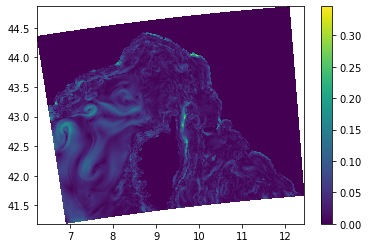

In [62]:
pc = plt.pcolormesh(lon_oce,lat_oce,np.sqrt(uc**2+vc**2))
plt.colorbar(pc)

In [48]:
ds_oce_grd


<xarray.Dataset>
Dimensions:    (bath: 1, eta_psi: 263, eta_rho: 264, eta_u: 264, eta_v: 263, one: 1, xi_psi: 346, xi_rho: 347, xi_u: 346, xi_v: 347)
Dimensions without coordinates: bath, eta_psi, eta_rho, eta_u, eta_v, one, xi_psi, xi_rho, xi_u, xi_v
Data variables: (12/34)
    xl         (one) float64 ...
    el         (one) float64 ...
    depthmin   (one) float64 ...
    depthmax   (one) float64 ...
    spherical  (one) |S1 ...
    angle      (eta_rho, xi_rho) float64 ...
    ...         ...
    lat_v      (eta_v, xi_v) float64 ...
    lat_psi    (eta_psi, xi_psi) float64 ...
    mask_rho   (eta_rho, xi_rho) float64 ...
    mask_u     (eta_u, xi_u) float64 ...
    mask_v     (eta_v, xi_v) float64 ...
    mask_psi   (eta_psi, xi_psi) float64 ...
Attributes:
    title:    d03coupled da zero
    date:     08-Dec-2015
    type:     ROMS grid file